# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

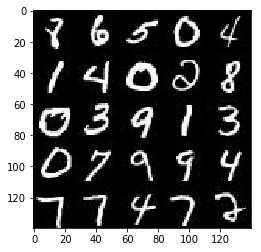

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

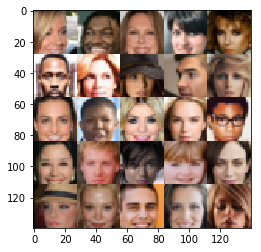

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/eallanjr/anaconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
# Define leaky relu
lrelu = lambda x: tf.maximum(0.01*x, x)


def conv(inputs, filters, ksize=5, strides=2, padding='same', batch_norm=True):
    """convenience function for creating convolutional layers"""
    x = tf.layers.conv2d(inputs, filters, ksize, strides, padding)
    return lrelu(x) if not batch_norm else lrelu(tf.layers.batch_normalization(x, training=True))


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = conv(images, 64, batch_norm=False)  # 28x28x3 -> 14x14x64, no batch_norm on first layer
        h2 = conv(h1, 128)  # 14x14x64 -> 7x7x128
        h3 = conv(h2, 256)  # 7x7x128 -> 4x4x256
        
        flattened = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
    
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7*7*256)
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = lrelu(tf.layers.batch_normalization(h1, training=is_train))
        
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, 1, padding='same')
        h2 = lrelu(tf.layers.batch_normalization(h2, training=is_train))
        
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, 2, padding='same')
        h3 = lrelu(tf.layers.batch_normalization(h3, training=is_train))
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, padding='same')
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run([d_train_opt, g_train_opt], 
                             feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.8142... Generator Loss: 16.9069
Epoch 1/2... Batch 20... Discriminator Loss: 0.3121... Generator Loss: 17.9565
Epoch 1/2... Batch 30... Discriminator Loss: 0.7271... Generator Loss: 16.0896
Epoch 1/2... Batch 40... Discriminator Loss: 0.1439... Generator Loss: 11.8445
Epoch 1/2... Batch 50... Discriminator Loss: 0.1728... Generator Loss: 3.6604
Epoch 1/2... Batch 60... Discriminator Loss: 0.4113... Generator Loss: 4.8736
Epoch 1/2... Batch 70... Discriminator Loss: 0.2059... Generator Loss: 2.7211
Epoch 1/2... Batch 80... Discriminator Loss: 0.3300... Generator Loss: 2.3569
Epoch 1/2... Batch 90... Discriminator Loss: 0.3451... Generator Loss: 8.5029
Epoch 1/2... Batch 100... Discriminator Loss: 0.3805... Generator Loss: 1.8148


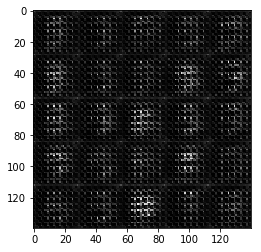

Epoch 1/2... Batch 110... Discriminator Loss: 0.5099... Generator Loss: 2.6818
Epoch 1/2... Batch 120... Discriminator Loss: 0.6306... Generator Loss: 2.1252
Epoch 1/2... Batch 130... Discriminator Loss: 0.4719... Generator Loss: 1.5244
Epoch 1/2... Batch 140... Discriminator Loss: 0.4846... Generator Loss: 2.2063
Epoch 1/2... Batch 150... Discriminator Loss: 0.4196... Generator Loss: 1.7128
Epoch 1/2... Batch 160... Discriminator Loss: 1.7560... Generator Loss: 0.4822
Epoch 1/2... Batch 170... Discriminator Loss: 0.4698... Generator Loss: 1.7616
Epoch 1/2... Batch 180... Discriminator Loss: 0.8660... Generator Loss: 1.0924
Epoch 1/2... Batch 190... Discriminator Loss: 0.9041... Generator Loss: 1.0129
Epoch 1/2... Batch 200... Discriminator Loss: 1.1882... Generator Loss: 0.6318


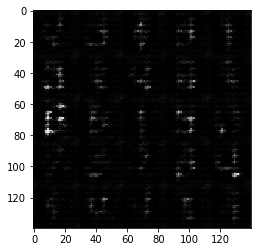

Epoch 1/2... Batch 210... Discriminator Loss: 0.6582... Generator Loss: 1.8817
Epoch 1/2... Batch 220... Discriminator Loss: 0.7916... Generator Loss: 1.2635
Epoch 1/2... Batch 230... Discriminator Loss: 0.5492... Generator Loss: 1.6572
Epoch 1/2... Batch 240... Discriminator Loss: 0.9097... Generator Loss: 3.0932
Epoch 1/2... Batch 250... Discriminator Loss: 1.5360... Generator Loss: 0.3736
Epoch 1/2... Batch 260... Discriminator Loss: 0.7035... Generator Loss: 2.1535
Epoch 1/2... Batch 270... Discriminator Loss: 0.7924... Generator Loss: 2.1018
Epoch 1/2... Batch 280... Discriminator Loss: 1.1975... Generator Loss: 0.5316
Epoch 1/2... Batch 290... Discriminator Loss: 0.5369... Generator Loss: 1.5119
Epoch 1/2... Batch 300... Discriminator Loss: 0.8120... Generator Loss: 1.3684


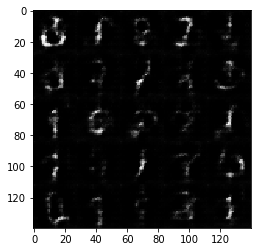

Epoch 1/2... Batch 310... Discriminator Loss: 0.6884... Generator Loss: 2.3747
Epoch 1/2... Batch 320... Discriminator Loss: 0.8967... Generator Loss: 2.1176
Epoch 1/2... Batch 330... Discriminator Loss: 0.7058... Generator Loss: 1.6108
Epoch 1/2... Batch 340... Discriminator Loss: 1.1347... Generator Loss: 0.6843
Epoch 1/2... Batch 350... Discriminator Loss: 1.8985... Generator Loss: 0.2560
Epoch 1/2... Batch 360... Discriminator Loss: 1.1304... Generator Loss: 0.6200
Epoch 1/2... Batch 370... Discriminator Loss: 1.1176... Generator Loss: 0.6844
Epoch 1/2... Batch 380... Discriminator Loss: 1.0564... Generator Loss: 1.9696
Epoch 1/2... Batch 390... Discriminator Loss: 0.8634... Generator Loss: 1.6419
Epoch 1/2... Batch 400... Discriminator Loss: 1.1551... Generator Loss: 0.6267


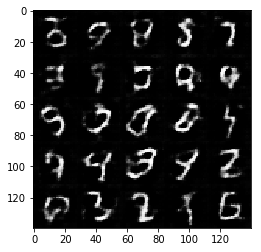

Epoch 1/2... Batch 410... Discriminator Loss: 1.6306... Generator Loss: 0.3152
Epoch 1/2... Batch 420... Discriminator Loss: 1.8299... Generator Loss: 0.2668
Epoch 1/2... Batch 430... Discriminator Loss: 0.8975... Generator Loss: 1.4095
Epoch 1/2... Batch 440... Discriminator Loss: 1.9868... Generator Loss: 3.8274
Epoch 1/2... Batch 450... Discriminator Loss: 0.9983... Generator Loss: 0.8113
Epoch 1/2... Batch 460... Discriminator Loss: 1.0354... Generator Loss: 2.4962
Epoch 2/2... Batch 470... Discriminator Loss: 0.9610... Generator Loss: 1.3998
Epoch 2/2... Batch 480... Discriminator Loss: 1.8263... Generator Loss: 0.2534
Epoch 2/2... Batch 490... Discriminator Loss: 0.7659... Generator Loss: 1.3869
Epoch 2/2... Batch 500... Discriminator Loss: 0.9316... Generator Loss: 0.8713


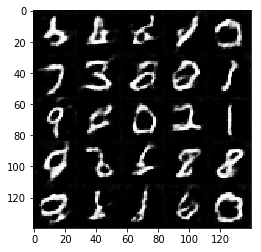

Epoch 2/2... Batch 510... Discriminator Loss: 1.1531... Generator Loss: 2.9585
Epoch 2/2... Batch 520... Discriminator Loss: 0.7538... Generator Loss: 1.1109
Epoch 2/2... Batch 530... Discriminator Loss: 1.0537... Generator Loss: 2.0074
Epoch 2/2... Batch 540... Discriminator Loss: 2.2691... Generator Loss: 0.1828
Epoch 2/2... Batch 550... Discriminator Loss: 0.8800... Generator Loss: 1.2046
Epoch 2/2... Batch 560... Discriminator Loss: 0.8246... Generator Loss: 1.0772
Epoch 2/2... Batch 570... Discriminator Loss: 1.1243... Generator Loss: 0.6691
Epoch 2/2... Batch 580... Discriminator Loss: 0.8327... Generator Loss: 1.7298
Epoch 2/2... Batch 590... Discriminator Loss: 1.7792... Generator Loss: 0.3575
Epoch 2/2... Batch 600... Discriminator Loss: 0.8746... Generator Loss: 2.1543


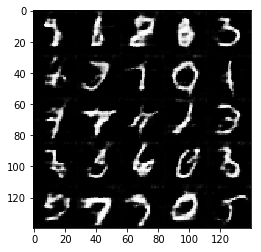

Epoch 2/2... Batch 610... Discriminator Loss: 0.8145... Generator Loss: 1.0467
Epoch 2/2... Batch 620... Discriminator Loss: 1.6254... Generator Loss: 0.3344
Epoch 2/2... Batch 630... Discriminator Loss: 1.2489... Generator Loss: 0.6092
Epoch 2/2... Batch 640... Discriminator Loss: 1.1499... Generator Loss: 1.0657
Epoch 2/2... Batch 650... Discriminator Loss: 1.6282... Generator Loss: 0.3652
Epoch 2/2... Batch 660... Discriminator Loss: 1.0315... Generator Loss: 1.5961
Epoch 2/2... Batch 670... Discriminator Loss: 0.8768... Generator Loss: 0.9272
Epoch 2/2... Batch 680... Discriminator Loss: 1.1833... Generator Loss: 0.6144
Epoch 2/2... Batch 690... Discriminator Loss: 0.9655... Generator Loss: 0.9356
Epoch 2/2... Batch 700... Discriminator Loss: 1.1339... Generator Loss: 0.6985


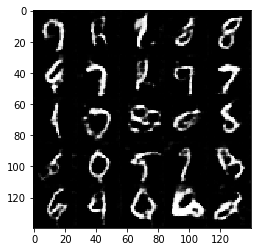

Epoch 2/2... Batch 710... Discriminator Loss: 0.8233... Generator Loss: 1.0164
Epoch 2/2... Batch 720... Discriminator Loss: 1.1718... Generator Loss: 2.2702
Epoch 2/2... Batch 730... Discriminator Loss: 1.2051... Generator Loss: 0.6101
Epoch 2/2... Batch 740... Discriminator Loss: 1.1035... Generator Loss: 0.7175
Epoch 2/2... Batch 750... Discriminator Loss: 0.9737... Generator Loss: 2.2043
Epoch 2/2... Batch 760... Discriminator Loss: 0.7707... Generator Loss: 1.0074
Epoch 2/2... Batch 770... Discriminator Loss: 1.3172... Generator Loss: 0.5009
Epoch 2/2... Batch 780... Discriminator Loss: 0.9051... Generator Loss: 1.2391
Epoch 2/2... Batch 790... Discriminator Loss: 1.0244... Generator Loss: 0.7786
Epoch 2/2... Batch 800... Discriminator Loss: 1.3071... Generator Loss: 0.5194


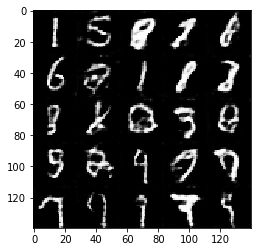

Epoch 2/2... Batch 810... Discriminator Loss: 0.8833... Generator Loss: 0.9298
Epoch 2/2... Batch 820... Discriminator Loss: 0.8982... Generator Loss: 0.8805
Epoch 2/2... Batch 830... Discriminator Loss: 1.1713... Generator Loss: 0.5695
Epoch 2/2... Batch 840... Discriminator Loss: 1.4389... Generator Loss: 0.4154
Epoch 2/2... Batch 850... Discriminator Loss: 1.1279... Generator Loss: 1.5954
Epoch 2/2... Batch 860... Discriminator Loss: 1.0689... Generator Loss: 0.8110
Epoch 2/2... Batch 870... Discriminator Loss: 1.3879... Generator Loss: 0.5026
Epoch 2/2... Batch 880... Discriminator Loss: 1.4317... Generator Loss: 0.4154
Epoch 2/2... Batch 890... Discriminator Loss: 0.9052... Generator Loss: 0.9301
Epoch 2/2... Batch 900... Discriminator Loss: 0.9440... Generator Loss: 1.0155


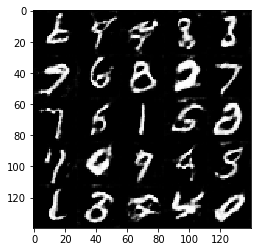

Epoch 2/2... Batch 910... Discriminator Loss: 1.0046... Generator Loss: 0.7135
Epoch 2/2... Batch 920... Discriminator Loss: 0.9138... Generator Loss: 1.0369
Epoch 2/2... Batch 930... Discriminator Loss: 1.2574... Generator Loss: 0.5363


In [25]:
batch_size = 128
z_dim = 100
learning_rate = .001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.2207... Generator Loss: 15.7462
Epoch 1/1... Batch 20... Discriminator Loss: 0.3313... Generator Loss: 1.3406
Epoch 1/1... Batch 30... Discriminator Loss: 0.1261... Generator Loss: 7.4387
Epoch 1/1... Batch 40... Discriminator Loss: 0.3806... Generator Loss: 16.0293
Epoch 1/1... Batch 50... Discriminator Loss: 2.9498... Generator Loss: 12.8969
Epoch 1/1... Batch 60... Discriminator Loss: 0.6460... Generator Loss: 1.7364
Epoch 1/1... Batch 70... Discriminator Loss: 0.4414... Generator Loss: 1.8892
Epoch 1/1... Batch 80... Discriminator Loss: 0.6595... Generator Loss: 2.7762
Epoch 1/1... Batch 90... Discriminator Loss: 2.3854... Generator Loss: 15.2617
Epoch 1/1... Batch 100... Discriminator Loss: 0.2039... Generator Loss: 4.1761


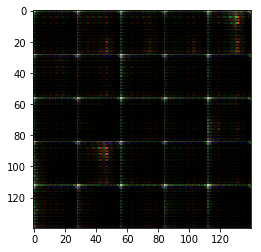

Epoch 1/1... Batch 110... Discriminator Loss: 3.0278... Generator Loss: 0.0875
Epoch 1/1... Batch 120... Discriminator Loss: 0.3792... Generator Loss: 2.7355
Epoch 1/1... Batch 130... Discriminator Loss: 0.6111... Generator Loss: 3.7098
Epoch 1/1... Batch 140... Discriminator Loss: 0.5621... Generator Loss: 4.2760
Epoch 1/1... Batch 150... Discriminator Loss: 0.1925... Generator Loss: 3.5619
Epoch 1/1... Batch 160... Discriminator Loss: 0.4422... Generator Loss: 2.5425
Epoch 1/1... Batch 170... Discriminator Loss: 0.5269... Generator Loss: 3.0526
Epoch 1/1... Batch 180... Discriminator Loss: 0.1874... Generator Loss: 3.3739
Epoch 1/1... Batch 190... Discriminator Loss: 1.4384... Generator Loss: 0.3969
Epoch 1/1... Batch 200... Discriminator Loss: 0.5438... Generator Loss: 2.1951


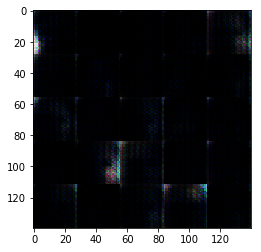

Epoch 1/1... Batch 210... Discriminator Loss: 0.6622... Generator Loss: 3.9214
Epoch 1/1... Batch 220... Discriminator Loss: 0.7140... Generator Loss: 1.1866
Epoch 1/1... Batch 230... Discriminator Loss: 4.1934... Generator Loss: 9.1386
Epoch 1/1... Batch 240... Discriminator Loss: 0.6712... Generator Loss: 2.5974
Epoch 1/1... Batch 250... Discriminator Loss: 1.1635... Generator Loss: 0.5232
Epoch 1/1... Batch 260... Discriminator Loss: 0.4334... Generator Loss: 1.5642
Epoch 1/1... Batch 270... Discriminator Loss: 0.6966... Generator Loss: 1.6657
Epoch 1/1... Batch 280... Discriminator Loss: 0.2102... Generator Loss: 2.2432
Epoch 1/1... Batch 290... Discriminator Loss: 0.6792... Generator Loss: 1.4029
Epoch 1/1... Batch 300... Discriminator Loss: 1.8727... Generator Loss: 0.2749


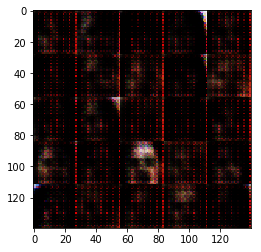

Epoch 1/1... Batch 310... Discriminator Loss: 0.3799... Generator Loss: 1.6438
Epoch 1/1... Batch 320... Discriminator Loss: 0.5589... Generator Loss: 2.0245
Epoch 1/1... Batch 330... Discriminator Loss: 0.8758... Generator Loss: 0.8131
Epoch 1/1... Batch 340... Discriminator Loss: 0.5345... Generator Loss: 1.7071
Epoch 1/1... Batch 350... Discriminator Loss: 0.7836... Generator Loss: 2.1006
Epoch 1/1... Batch 360... Discriminator Loss: 0.4872... Generator Loss: 1.8285
Epoch 1/1... Batch 370... Discriminator Loss: 1.5585... Generator Loss: 0.3563
Epoch 1/1... Batch 380... Discriminator Loss: 0.3765... Generator Loss: 1.8540
Epoch 1/1... Batch 390... Discriminator Loss: 1.4077... Generator Loss: 7.4894
Epoch 1/1... Batch 400... Discriminator Loss: 0.5508... Generator Loss: 1.4211


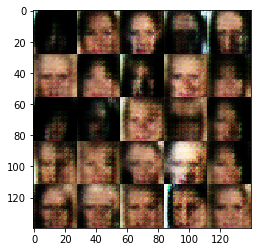

Epoch 1/1... Batch 410... Discriminator Loss: 0.3038... Generator Loss: 2.1611
Epoch 1/1... Batch 420... Discriminator Loss: 0.8744... Generator Loss: 0.9181
Epoch 1/1... Batch 430... Discriminator Loss: 1.1293... Generator Loss: 0.5805
Epoch 1/1... Batch 440... Discriminator Loss: 0.4739... Generator Loss: 2.3899
Epoch 1/1... Batch 450... Discriminator Loss: 1.7309... Generator Loss: 7.7608
Epoch 1/1... Batch 460... Discriminator Loss: 0.8762... Generator Loss: 0.8425
Epoch 1/1... Batch 470... Discriminator Loss: 0.4786... Generator Loss: 1.7213
Epoch 1/1... Batch 480... Discriminator Loss: 0.7060... Generator Loss: 1.1431
Epoch 1/1... Batch 490... Discriminator Loss: 2.3170... Generator Loss: 8.8449
Epoch 1/1... Batch 500... Discriminator Loss: 0.6412... Generator Loss: 1.7159


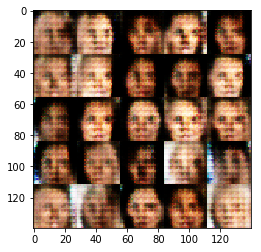

Epoch 1/1... Batch 510... Discriminator Loss: 0.4254... Generator Loss: 3.4869
Epoch 1/1... Batch 520... Discriminator Loss: 0.3889... Generator Loss: 1.9053
Epoch 1/1... Batch 530... Discriminator Loss: 2.3356... Generator Loss: 6.6068
Epoch 1/1... Batch 540... Discriminator Loss: 0.4771... Generator Loss: 2.1291
Epoch 1/1... Batch 550... Discriminator Loss: 0.5726... Generator Loss: 1.2081
Epoch 1/1... Batch 560... Discriminator Loss: 0.7527... Generator Loss: 1.1574
Epoch 1/1... Batch 570... Discriminator Loss: 0.7316... Generator Loss: 1.0616
Epoch 1/1... Batch 580... Discriminator Loss: 0.5314... Generator Loss: 2.7868
Epoch 1/1... Batch 590... Discriminator Loss: 0.7390... Generator Loss: 3.4779
Epoch 1/1... Batch 600... Discriminator Loss: 1.1053... Generator Loss: 0.5132


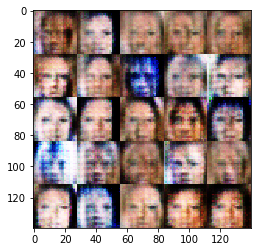

Epoch 1/1... Batch 610... Discriminator Loss: 0.5918... Generator Loss: 1.4795
Epoch 1/1... Batch 620... Discriminator Loss: 0.5305... Generator Loss: 2.0276
Epoch 1/1... Batch 630... Discriminator Loss: 0.9822... Generator Loss: 0.8397
Epoch 1/1... Batch 640... Discriminator Loss: 0.8484... Generator Loss: 0.8491
Epoch 1/1... Batch 650... Discriminator Loss: 0.3783... Generator Loss: 2.3486
Epoch 1/1... Batch 660... Discriminator Loss: 0.2654... Generator Loss: 2.8013
Epoch 1/1... Batch 670... Discriminator Loss: 0.5787... Generator Loss: 1.8561
Epoch 1/1... Batch 680... Discriminator Loss: 0.6754... Generator Loss: 1.2524
Epoch 1/1... Batch 690... Discriminator Loss: 0.5577... Generator Loss: 1.4750
Epoch 1/1... Batch 700... Discriminator Loss: 0.7734... Generator Loss: 2.4768


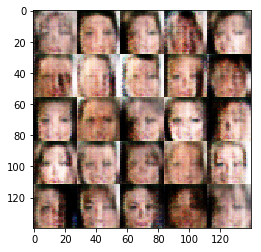

Epoch 1/1... Batch 710... Discriminator Loss: 0.6743... Generator Loss: 2.7849
Epoch 1/1... Batch 720... Discriminator Loss: 0.9024... Generator Loss: 0.7340
Epoch 1/1... Batch 730... Discriminator Loss: 0.5990... Generator Loss: 2.0924
Epoch 1/1... Batch 740... Discriminator Loss: 0.7649... Generator Loss: 1.0471
Epoch 1/1... Batch 750... Discriminator Loss: 0.7473... Generator Loss: 1.1094
Epoch 1/1... Batch 760... Discriminator Loss: 0.6743... Generator Loss: 1.1996
Epoch 1/1... Batch 770... Discriminator Loss: 2.5808... Generator Loss: 5.1944
Epoch 1/1... Batch 780... Discriminator Loss: 0.4593... Generator Loss: 3.0677
Epoch 1/1... Batch 790... Discriminator Loss: 0.9163... Generator Loss: 0.8849
Epoch 1/1... Batch 800... Discriminator Loss: 0.5672... Generator Loss: 1.4941


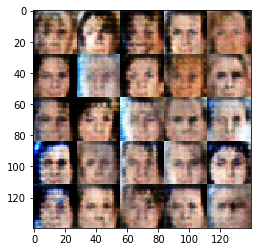

Epoch 1/1... Batch 810... Discriminator Loss: 0.6532... Generator Loss: 1.1239
Epoch 1/1... Batch 820... Discriminator Loss: 0.3522... Generator Loss: 2.5246
Epoch 1/1... Batch 830... Discriminator Loss: 0.7667... Generator Loss: 1.4153
Epoch 1/1... Batch 840... Discriminator Loss: 0.4065... Generator Loss: 2.4075
Epoch 1/1... Batch 850... Discriminator Loss: 0.7064... Generator Loss: 2.6790
Epoch 1/1... Batch 860... Discriminator Loss: 1.0107... Generator Loss: 0.7787
Epoch 1/1... Batch 870... Discriminator Loss: 1.5789... Generator Loss: 0.4113
Epoch 1/1... Batch 880... Discriminator Loss: 1.2938... Generator Loss: 0.4554
Epoch 1/1... Batch 890... Discriminator Loss: 0.7703... Generator Loss: 1.1850
Epoch 1/1... Batch 900... Discriminator Loss: 0.5488... Generator Loss: 2.5608


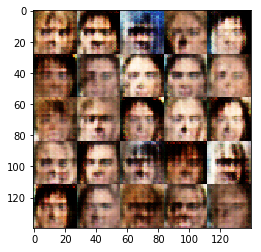

Epoch 1/1... Batch 910... Discriminator Loss: 0.6528... Generator Loss: 1.2387
Epoch 1/1... Batch 920... Discriminator Loss: 0.4508... Generator Loss: 2.2859
Epoch 1/1... Batch 930... Discriminator Loss: 0.6979... Generator Loss: 1.2767
Epoch 1/1... Batch 940... Discriminator Loss: 0.7628... Generator Loss: 1.0030
Epoch 1/1... Batch 950... Discriminator Loss: 0.7661... Generator Loss: 1.1315
Epoch 1/1... Batch 960... Discriminator Loss: 0.6709... Generator Loss: 1.2264
Epoch 1/1... Batch 970... Discriminator Loss: 0.8059... Generator Loss: 1.1531
Epoch 1/1... Batch 980... Discriminator Loss: 0.8284... Generator Loss: 0.8900
Epoch 1/1... Batch 990... Discriminator Loss: 0.8132... Generator Loss: 4.2073
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7549... Generator Loss: 0.9553


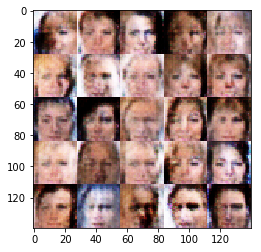

Epoch 1/1... Batch 1010... Discriminator Loss: 0.9434... Generator Loss: 0.7352
Epoch 1/1... Batch 1020... Discriminator Loss: 0.6985... Generator Loss: 1.3251
Epoch 1/1... Batch 1030... Discriminator Loss: 0.7653... Generator Loss: 1.0499
Epoch 1/1... Batch 1040... Discriminator Loss: 0.3797... Generator Loss: 2.0572
Epoch 1/1... Batch 1050... Discriminator Loss: 0.5398... Generator Loss: 2.6859
Epoch 1/1... Batch 1060... Discriminator Loss: 0.5840... Generator Loss: 1.5666
Epoch 1/1... Batch 1070... Discriminator Loss: 2.5838... Generator Loss: 7.6921
Epoch 1/1... Batch 1080... Discriminator Loss: 0.4957... Generator Loss: 1.4600
Epoch 1/1... Batch 1090... Discriminator Loss: 0.4686... Generator Loss: 2.0047
Epoch 1/1... Batch 1100... Discriminator Loss: 0.7302... Generator Loss: 1.0277


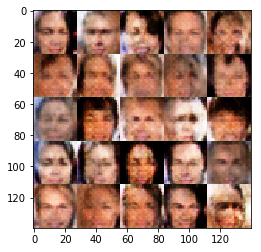

Epoch 1/1... Batch 1110... Discriminator Loss: 0.3653... Generator Loss: 1.7711
Epoch 1/1... Batch 1120... Discriminator Loss: 1.2452... Generator Loss: 0.5347
Epoch 1/1... Batch 1130... Discriminator Loss: 0.8715... Generator Loss: 0.8565
Epoch 1/1... Batch 1140... Discriminator Loss: 0.6745... Generator Loss: 1.2916
Epoch 1/1... Batch 1150... Discriminator Loss: 0.5260... Generator Loss: 2.1369
Epoch 1/1... Batch 1160... Discriminator Loss: 0.7518... Generator Loss: 0.8304
Epoch 1/1... Batch 1170... Discriminator Loss: 0.7010... Generator Loss: 1.1853
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4278... Generator Loss: 0.4231
Epoch 1/1... Batch 1190... Discriminator Loss: 0.6435... Generator Loss: 1.9227
Epoch 1/1... Batch 1200... Discriminator Loss: 0.9576... Generator Loss: 0.9085


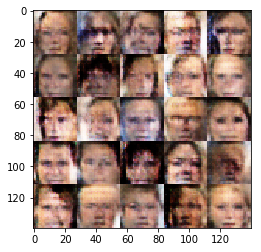

Epoch 1/1... Batch 1210... Discriminator Loss: 0.7783... Generator Loss: 1.0379
Epoch 1/1... Batch 1220... Discriminator Loss: 0.5057... Generator Loss: 1.8503
Epoch 1/1... Batch 1230... Discriminator Loss: 0.6924... Generator Loss: 1.3098
Epoch 1/1... Batch 1240... Discriminator Loss: 0.6787... Generator Loss: 1.8434
Epoch 1/1... Batch 1250... Discriminator Loss: 0.7225... Generator Loss: 1.2923
Epoch 1/1... Batch 1260... Discriminator Loss: 0.5857... Generator Loss: 2.5406
Epoch 1/1... Batch 1270... Discriminator Loss: 0.6158... Generator Loss: 2.9477
Epoch 1/1... Batch 1280... Discriminator Loss: 0.6137... Generator Loss: 1.9193
Epoch 1/1... Batch 1290... Discriminator Loss: 0.8331... Generator Loss: 2.5394
Epoch 1/1... Batch 1300... Discriminator Loss: 2.6047... Generator Loss: 0.1375


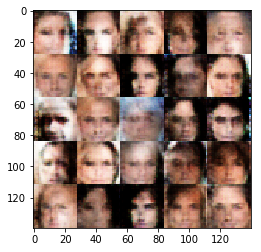

Epoch 1/1... Batch 1310... Discriminator Loss: 0.7069... Generator Loss: 1.1434
Epoch 1/1... Batch 1320... Discriminator Loss: 0.8608... Generator Loss: 2.5336
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1129... Generator Loss: 0.6167
Epoch 1/1... Batch 1340... Discriminator Loss: 0.6304... Generator Loss: 3.1098
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3830... Generator Loss: 0.5204
Epoch 1/1... Batch 1360... Discriminator Loss: 0.7922... Generator Loss: 2.9005
Epoch 1/1... Batch 1370... Discriminator Loss: 0.6666... Generator Loss: 1.3973
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2235... Generator Loss: 0.6429
Epoch 1/1... Batch 1390... Discriminator Loss: 0.5618... Generator Loss: 1.6182
Epoch 1/1... Batch 1400... Discriminator Loss: 0.8658... Generator Loss: 3.9277


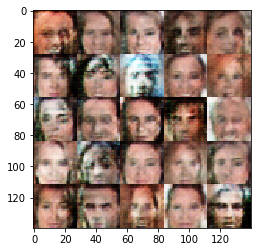

Epoch 1/1... Batch 1410... Discriminator Loss: 0.7079... Generator Loss: 3.4758
Epoch 1/1... Batch 1420... Discriminator Loss: 0.6986... Generator Loss: 1.1517
Epoch 1/1... Batch 1430... Discriminator Loss: 0.4873... Generator Loss: 2.7731
Epoch 1/1... Batch 1440... Discriminator Loss: 0.7477... Generator Loss: 1.8028
Epoch 1/1... Batch 1450... Discriminator Loss: 0.8769... Generator Loss: 0.8713
Epoch 1/1... Batch 1460... Discriminator Loss: 0.6055... Generator Loss: 1.9722
Epoch 1/1... Batch 1470... Discriminator Loss: 0.7583... Generator Loss: 2.5218
Epoch 1/1... Batch 1480... Discriminator Loss: 1.6523... Generator Loss: 0.4317
Epoch 1/1... Batch 1490... Discriminator Loss: 0.7343... Generator Loss: 1.7963
Epoch 1/1... Batch 1500... Discriminator Loss: 0.8661... Generator Loss: 0.9990


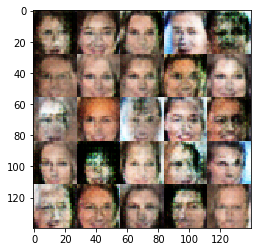

Epoch 1/1... Batch 1510... Discriminator Loss: 2.4204... Generator Loss: 6.0533
Epoch 1/1... Batch 1520... Discriminator Loss: 1.2932... Generator Loss: 0.5409
Epoch 1/1... Batch 1530... Discriminator Loss: 0.6012... Generator Loss: 1.7749
Epoch 1/1... Batch 1540... Discriminator Loss: 0.8890... Generator Loss: 0.8725
Epoch 1/1... Batch 1550... Discriminator Loss: 0.7541... Generator Loss: 1.1036
Epoch 1/1... Batch 1560... Discriminator Loss: 1.4197... Generator Loss: 4.0690
Epoch 1/1... Batch 1570... Discriminator Loss: 0.6698... Generator Loss: 1.2440
Epoch 1/1... Batch 1580... Discriminator Loss: 0.9516... Generator Loss: 0.8596


In [26]:
batch_size = 128
z_dim = 100
learning_rate = .001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.